BACKTRADER TUTORIAL

Installing Backtrader and yfinance Library

In [ ]:
!pip install backtrader
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing the necessary packages

In [ ]:
import backtrader as bt
import backtrader.analyzers as btanalyzers
import backtrader.feeds as btfeeds
import backtrader.strategies as btstrats
import backtrader.indicators
import datetime
import yfinance as yf
import matplotlib as plt

Creating a Strategy Class

Strategy:
Go Long when ever a fast sma crosses slow sma and close the position when the slow sma crosses fast sma

In [ ]:
class SMAC(bt.Strategy):

    # Creating Parameters to customize the strategy
    params = (('sma_fast', 14), ('sma_slow', 50)) # Lookback Period for the SMA's

    def __init__(self):
        self.order = None
        self.closepos = None
        self.sma1 = bt.indicators.SMA(self.data.close, period=self.params.sma_fast)  # Initialise the faster EMA
        self.sma2 = bt.indicators.SMA(self.data.close, period=self.params.sma_slow)  # Initialise the slower EMA
        self.crossover = bt.ind.CrossOver(self.sma1, self.sma2) # crossover signal - fast sma moves above slow sma

    def log(self, txt, doprint=True): # Function to print out log details
        date = self.data.datetime.date(0)
        time = self.data.datetime.time(0)
        if doprint:
            print(str(date) + '--' + txt)


    def notify_order(self, order): # Function to notify when a new order is being executed or cancelled
        if order.status in [order.Submitted, order.Accepted]: # To check if an order has been completed
            return
        elif order.status == order.Completed: # To notify placed orders
            if order.isbuy(): # To notify buy
                self.log('BUY   price: {}, value: {}, commission: {}'.format(order.executed.price, order.executed.value, order.executed.comm))
            if order.issell(): # To notify sell
                self.log('SELL   price: {}, value: {}, commission: {}'.format(order.executed.price, order.executed.value, order.executed.comm))
        elif order.status in [order.Rejected, order.Margin]: # To notify cancelled orders
            self.log('Order Rejected/Margin')

        self.order = None # to write down no pending order


    def notify_trade(self, trade): # Funtion to notify about pnl after closing a trade
        if trade.isclosed:
            self.log('CLOSE   Gross P/L: {}, Net P/L: {}'.format(trade.pnl, trade.pnlcomm))


    def next(self): # Function which contains the strategy in it

        if self.position.size == 0: # If we are not in any position
                if (self.crossover > 0): # Condition to enter Long
                    self.order = self.buy() # Place buy order

        if self.position.size > 0: # If we are in a long position
            if (self.crossover < 0): # Condition to close open long positions
                self.closepos = self.close() # Closing our buy position

Adding a Data Feed.
Setting the Cash, along with commission to be given



In [ ]:
cerebro = bt.Cerebro() # Instantiating the cerebro engine

datapath = 'TITAN.NS.csv' # To set a sub-folder from where data feed will be collected
feed = bt.feeds.PandasData(dataname=yf.download('TITAN.NS', '2018-01-01', '2023-04-30')) # To set the data feed
cerebro.adddata(feed) # To feed the data into Cerebro engine

cerebro.addstrategy(SMAC) # To add the strategy
cerebro.broker.setcash(100000.0) # To set initial portfolio value
cerebro.broker.setcommission(commission=.0002) # To set broker commission

cerebro.addsizer(bt.sizers.PercentSizer, percents=90) # To allocate percentage of portfolio to execute an order

[*********************100%***********************]  1 of 1 completed


In [ ]:
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")

Printing trade logs

In [ ]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue()) # Print the initial portfolio value
backtest_result = cerebro.run() # Setting cerebro to run (loop over the data)
backtest_result_1 = backtest_result[0]
final = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % final) # Print the final portfolio value
print('Sharpe Ratio:', backtest_result_1.analyzers.mysharpe.get_analysis()) # Print the Sharpe ratio

Starting Portfolio Value: 100000.00
2018-03-26--BUY   price: 896.4500122070312, value: 90140.77671524954, commission: 18.028155343049907
2018-05-28--SELL   price: 928.0, value: 90140.77671524954, commission: 18.66264479952571
2018-05-28--CLOSE   Gross P/L: 3172.44728237903, Net P/L: 3135.7564822364548
2018-08-06--BUY   price: 928.7000122070311, value: 93781.5049269334, commission: 18.75630098538668
2018-09-12--SELL   price: 817.0, value: 93781.5049269334, commission: 16.50037439823445
2018-09-12--CLOSE   Gross P/L: -11279.63293576115, Net P/L: -11314.889611144772
2018-11-13--BUY   price: 889.2000122070312, value: 82126.18535721868, commission: 16.425237071443735
2019-07-17--SELL   price: 1110.25, value: 82126.18535721868, commission: 20.508456149598565
2019-07-17--CLOSE   Gross P/L: 20416.09539077414, Net P/L: 20379.161697553096
2019-09-18--BUY   price: 1163.0, value: 101394.1462575441, commission: 20.27882925150882
2019-11-19--SELL   price: 1158.800048828125, value: 101394.1462575441,

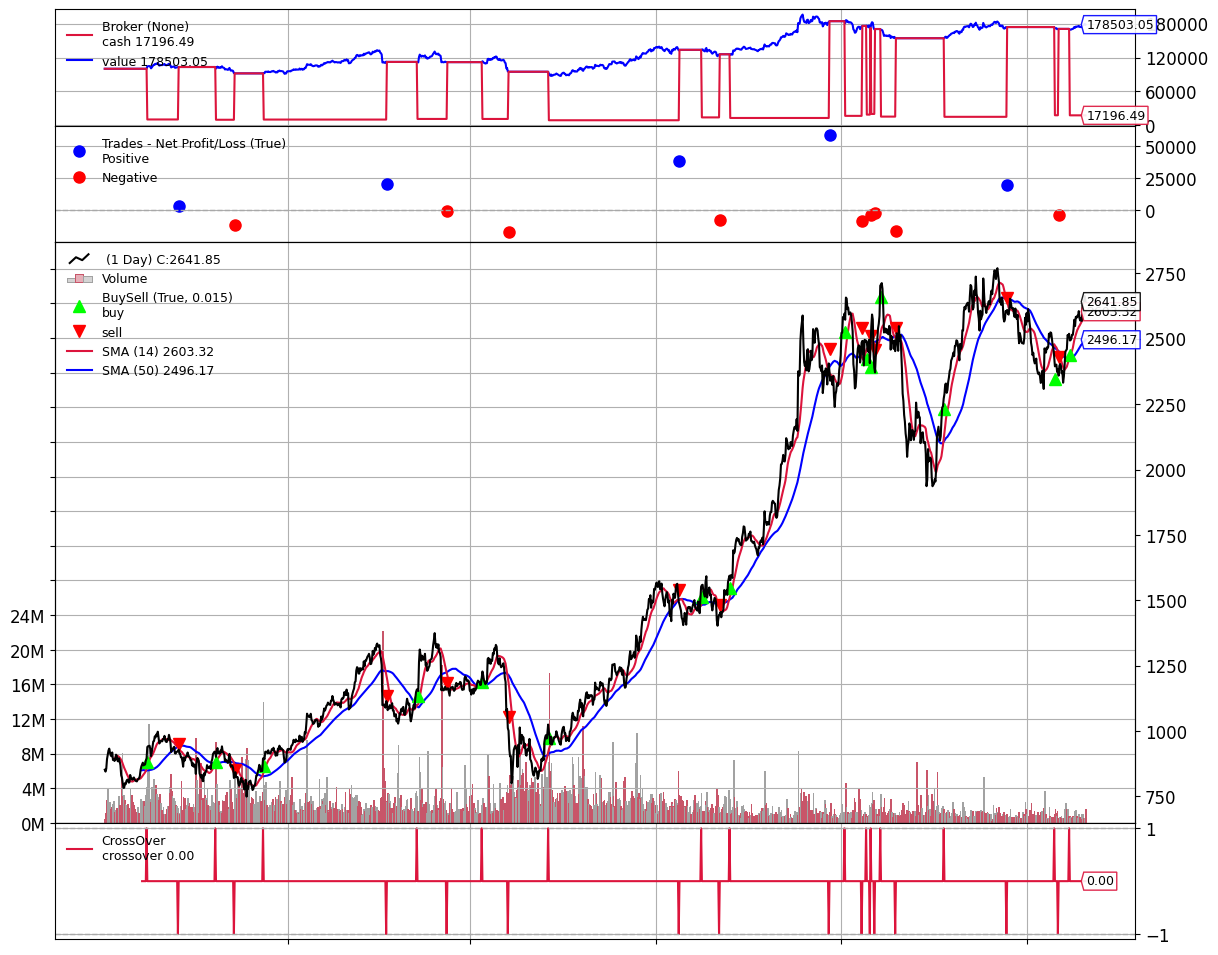

[[<Figure size 1200x1000 with 5 Axes>]]

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams.update({'font.size': 12})
cerebro.plot(iplot = False) # To plot the result